In [3]:
from opacus.accountants.analysis import rdp as privacy_analysis
import numpy as np
import math

def generate_rdp_orders():
    dense = 1.07
    alpha_list = [int(dense ** i + 1) for i in range(int(math.floor(math.log(1000, dense))) + 1)]
    alpha_list = np.unique(alpha_list)
    return alpha_list


def F_dp(r, s, weights, values):
    # Initialize a DP table with (r+1) rows and (s+1) columns
    dp = [[0] * (s + 1) for _ in range(r + 1)]

    # Base case: when no items are selected, the value is 1
    for j in range(s + 1):
        dp[0][j] = 1

        # Fill the DP table
    for i in range(1, r + 1):
        ar = weights[i - 1]
        wr = values[i - 1]
        for j in range(s + 1):
            if ar <= j:
                dp[i][j] = dp[i - 1][j] + wr * dp[i - 1][j - ar]
            else:
                dp[i][j] = dp[i - 1][j]

    return dp[r][s]


def calculate_optcomp(k, epsilons, deltas, a_g, eps_0, delta_g, a_i):
    epsilon_g = a_g * eps_0

    # compute left_side_result
    # Calculate the product (1 + exp(epsilon_i))
    product_term = np.prod([1 + np.exp(e) for e in epsilons])

    # compute F(k,B)
    B = (np.sum(a_i) - a_g) // 2

    values_1 = [np.exp(-e) for e in epsilons]
    F_1 = F_dp(k, B, a_i, values_1)

    values_2 = [np.exp(e) for e in epsilons]
    F_2 = F_dp(k, B, a_i, values_2)

    sum_term = np.prod([np.exp(e) for e in epsilons]) * F_1 - np.exp(epsilon_g) * F_2

    # Divide by product term
    left_side_result = sum_term / product_term

    # compute right_side_result
    # Calculate the product (1 - delta)
    product_term_ = np.prod([1 - d for d in deltas])

    right_side_result = 1 - ((1 - delta_g) / product_term_)

    return left_side_result - right_side_result


def binary_search_epsilon_g(eps_0, k, epsilons, deltas, delta_g, a_i):
    a, b = 1, sum(a_i)  # Initial bounds
    i = 0
    while b >= a:
        i += 1
        m = (a + b) // 2
        result = calculate_optcomp(k, epsilons, deltas, m, eps_0, delta_g, a_i)
        if result < 0:
            b = m - 1
        elif result > 0:
            a = m + 1
        else:
            return m, m * eps_0
    return (a + b) // 2 + 1, ((a + b) // 2 + 1) * eps_0

In [4]:
# compute the privacy cost of a step
def compute_privacy_cost_one_step(noise_multiplier, sample_rate, delta):
    alphas = generate_rdp_orders()
    orders_vec = np.atleast_1d(alphas)
    inner_rdp = privacy_analysis.compute_rdp(q=sample_rate, noise_multiplier=noise_multiplier, steps=1,
                                             orders=alphas)
    eps_vec = (
            inner_rdp
            - (np.log(delta) + np.log(orders_vec)) / (orders_vec - 1)
            + np.log((orders_vec - 1) / orders_vec)
    )
    idx_opt = np.nanargmin(eps_vec)
    eps = eps_vec[idx_opt]
    eps = eps * sample_rate
    return eps, delta 

# compute the total privacy cost from the beginning
def get_privacy_spent(privacy_costs, deltas, delta_g, eta):
    eps_mean = sum(privacy_costs) / len(privacy_costs)
    beta = eta / (len(privacy_costs) * (1 + eps_mean) + 1)
    eps_0 = np.log(1 + beta)
    a = []
    eps_pie = []
    for eps_i in privacy_costs:
        a_i = math.ceil(eps_i * (1 / beta + 1))
        eps_i_pie = eps_0 * a_i
        a.append(a_i)
        eps_pie.append(eps_i_pie)
    a_g, epsilon_g = binary_search_epsilon_g(eps_0, len(privacy_costs), 
                                             eps_pie, deltas, delta_g, a)
    return a_g, epsilon_g

In [5]:
privacy_costs = []
deltas = []
for i in range(int(50 * 5 * 1.5)):
    eps, delta = compute_privacy_cost_one_step(
        noise_multiplier=5, sample_rate=0.25, delta=0.001
    )
    privacy_costs.append(eps)
    deltas.append(delta)
print(f"eps:{eps}")
_, eps_high = get_privacy_spent(privacy_costs, deltas, delta_g=0.1, eta=0.5)
print(f"eps_high:{eps_high}")

eps:0.03262578387950946
eps_high:12.550046533730349


In [1]:
from opacus.accountants.utils import get_noise_multiplier_with_fed_rdp
noise_configs = [
    {'type': 'constant'},
    {'type': 'step', 'beta': 0.5},
    {'type': 'log', 'decay_rate': 0.5},
    {'type': 'double_log', 'decay_rate': 0.5}
]

for noise_config in noise_configs:
    noise_multiplier = get_noise_multiplier_with_fed_rdp(
        target_epsilon=10,
        rounds=50,
        steps=2,
        recover_rounds=25,
        recover_steps=1,
        sample_rate=0.25,
        delta=0.001,
        delta_g=0.1,
        eta=0.5,
        noise_config=noise_config
    )
    print(noise_multiplier)

2.87109375
3.5546875
8.4765625
10.859375


8.4765625


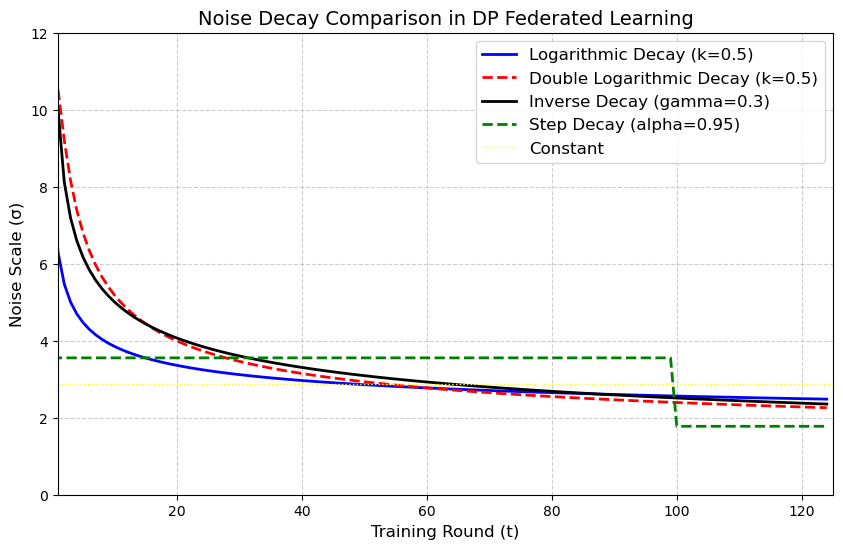

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 噪声衰减函数定义
def logarithmic_decay(round_num, initial_noise=8.4765625, decay_rate=0.5, min_noise=1.0):
    noise = initial_noise / (1 + decay_rate * np.log(round_num + 1))
    return max(noise, min_noise)

def double_logarithmic_decay(round_num, initial_noise=10.859375, decay_rate=0.5, min_noise=1.0):
    noise = initial_noise / (1 + decay_rate * np.log(round_num + 1) * np.log(np.log(round_num + 2)))
    return max(noise, min_noise)

def step_decay(round_num, initial_noise=3.5546875, change_round=100, gamma=0.5):
    noise = initial_noise *( gamma ** (round_num // change_round))
    return noise

def inverse_decay(round_num, initial_noise=10.0, gamma=0.3, min_noise=1.0):
    noise = initial_noise / max((round_num ** gamma), 1.0)
    return max(noise, min_noise)

# def exp_decay(round_num, initial_noise=10.0, alpha=0.95, min_noise=1.0):
#     noise = initial_noise * (alpha ** round_num)
#     return max(noise, min_noise)

# 生成轮次数据（1到125轮）
rounds = np.arange(0, 125)
log_noise = [logarithmic_decay(t) for t in rounds]
dlog_noise = [double_logarithmic_decay(t) for t in rounds]
inv_noise = [inverse_decay(t) for t in rounds]
step_noise = [step_decay(t) for t in rounds]
# 绘制曲线
plt.figure(figsize=(10, 6))
plt.plot(rounds, log_noise, 'b-', linewidth=2, label='Logarithmic Decay (k=0.5)')
plt.plot(rounds, dlog_noise, 'r--', linewidth=2, label='Double Logarithmic Decay (k=0.5)')
plt.plot(rounds, inv_noise, color='black', linestyle='-', linewidth=2, label='Inverse Decay (gamma=0.3)')
plt.plot(rounds, step_noise, color='green', linestyle='--', linewidth=2, label='Step Decay (alpha=0.95)')
plt.axhline(y=2.87109375, color='yellow', linestyle=':', linewidth=1, label='Constant')

# 图表装饰
plt.title('Noise Decay Comparison in DP Federated Learning', fontsize=14)
plt.xlabel('Training Round (t)', fontsize=12)
plt.ylabel('Noise Scale (σ)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(1, 125)
plt.ylim(0, 12)
plt.show()

In [6]:
def logarithmic_decay(round_num, initial_noise=10.0, decay_rate=0.5, min_noise=1.0):
    noise = initial_noise / (1 + decay_rate * np.log(round_num + 1))
    return max(noise, min_noise)
for i in range(1, 126):
    noise = logarithmic_decay(i)
    print(noise)

7.426255848312643
6.454502253522233
5.906161091496412
5.541028959412846
5.274596176869758
5.068539131532982
4.902631842044826
4.765053580405043
4.648368264131778
4.547629890985114
4.459401624545606
4.381209611298194
4.3112207026031095
4.248043063627011
4.190597841964052
4.1380337626923875
4.089668636685402
4.044948291256232
4.003417097804541
3.9646964101969457
3.9284685176425826
3.894464516767343
3.862455017903141
3.83224293337255
3.8036578171167634
3.7765513753617292
3.750793871809475
3.726271223632255
3.702882636339654
3.6805386629346946
3.6591596000376367
3.638674153786474
3.6190183233456557
3.6001344611768418
3.5819704778381514
3.564479165686942
3.5476176209732073
3.5313467477956317
3.5156308305209247
3.5004371637402594
3.4857357308041945
3.471498923552372
3.4577012971222074
3.444319354747118
3.4313313582899574
3.4187171609403144
3.4064580590653817
3.394536660667255
3.382936768283365
3.37164327448623
3.360642068405714
3.349919951920856
3.3394645643568683
3.3292643146820966
3.319308